!["question"](question.jpg)



between layer 1 and 2:

$$
\begin{bmatrix}
  b_{10} & w_{11} & w_{21} \\
  b_{20} & w_{12} & w_{22} 
\end{bmatrix}
$$

where b = bias and w = weights

$x = [0.1,0.2]$

In [1]:
import numpy as np
from sklearn.datasets import load_iris


input is columns, output is rows 

In [2]:
def Linear(num_nodes_input_layer, num_nodes_output_layer):
    """Dimensions: output is rows, input is columns."""
    weights = np.random.rand(num_nodes_output_layer, num_nodes_input_layer + 1) * 0.01
    # biases = np.ones((weights.shape[0], 1))

    # Stack the original array and the column of ones
    # return np.column_stack((biases, weights ))
    return weights


# Forward propogation to make predictions

!["how to apply the weights"](apply_weights.png)

$$ output = 
\begin{bmatrix}
  Neuron\:1\:applied\:to\:sample\:1 & Neuron\:2\:applied\:to\:sample\:1 \\
  Neuron\:1\:applied\:to\:sample\:2 & Neuron\:2\:applied\:to\:sample\:2
\end{bmatrix}
$$

In [3]:
def compute_forward(inputs, layer):
    ## linear combination w0x0 + w1x1 + w2x2
    linear_combinations = []
    # print(inputs, inputs.shape)
    # print(np.ones(inputs.shape[1]))
    inputs = np.c_[ np.ones(inputs.shape[0]), inputs  ]    ## add bias to the inputs
    # print(inputs)
    # print(layer)

    linear_combinations = np.matmul(inputs, layer.T) ## logits or z
    
    # print(linear_combinations)

    sigmoids = 1/(  1 + np.exp( -linear_combinations ) ) ## compute a
    # print(sigmoids)

    return linear_combinations, sigmoids


# def sigmoid(inputs, layer):

#     linear_combinations = np.matmul(inputs, layer.T) ## logits
#     return 1/(  1 + np.exp( -linear_combinations ) ) ## compute a

# Loss function

*m is number of samples*

*k is total number of output units*
$$
 J(θ)= - \frac{1}{m} {\sum^m_{i=1}\sum^k_{k=1} [y^{(i)}_kln(\frac{1}{1+e^{xθ^T}})_k + (1-y^{(i)}_k)ln(1-(\frac{1}{1+e^{xθ^T}})_k)]} 
$$
$$
 = \frac{1}{m} {\sum^m_{i=1}\sum^k_{k=1} [y^{(i)}_kln(a^{(L)}_k) + (1-y^{(i)}_k)ln(1-a^{(L)}_k)]}

$$


$$  
output\_sigmoids = 
\begin{bmatrix}
  Neuron\:1\:applied\:to\:sample\:1 & Neuron\:2\:applied\:to\:sample\:1 \\
  Neuron\:1\:applied\:to\:sample\:2 & Neuron\:2\:applied\:to\:sample\:2
\end{bmatrix}
$$

In [4]:
def binary_cross_entropy_loss(output_sigmoids, target):
    
    ## m is number of samples
    ## k is total number of output units

    target = target.reshape(-1,1)
    log_sigmoids = np.log(output_sigmoids)
    y_times_log_sigmoids = log_sigmoids * target ## element-wise multiplication

    one_minus_log_sigmoids = np.log(1 - output_sigmoids)
    one_minus_y_times_log_sigmoids = one_minus_log_sigmoids * (1 - target) ## element-wise multiplication
    # print(one_minus_y_times_log_sigmoids)
    
    return sum(sum((y_times_log_sigmoids + one_minus_y_times_log_sigmoids)))/len(target) * -1 ## sum across the output units and sum across the samples





# Backpropogation

want: $\frac{∂J(θ)}{∂θ^{(l)}_{ij}}$ for $l=1,2$

for each

$$δ^{(L)} = \begin{bmatrix}
  a^{(L)}_{1} - y_{11} \\
  a^{(L)}_{2} - y_{12} \\
  a^{(L)}_1 - y_{21} \\ 
  a^{(L)}_1 - y_{22} \\ 

\end{bmatrix}
$$

for the last layer <br>
$y_{11}$ is sample $1$, for target $1 $

$$δ^{(L)} * \begin{bmatrix} a^{(L-1)}_{0}  a^{(L-1)}_{1} a^{(L-1)}_2 \end{bmatrix} = \begin{bmatrix}
  \frac{∂J(θ)}{∂θ^{(L-1)}_{10}} & \frac{∂J(θ)}{∂θ^{(L-1)}_{11}} & \frac{∂J(θ)}{∂θ^{(L-1)}_{12}} \\
  \\
  \frac{∂J(θ)}{∂θ^{(L-1)}_{20}} & \frac{∂J(θ)}{∂θ^{(L-1)}_{21}} & \frac{∂J(θ)}{∂θ^{(L-1)}_{22}} \\


\end{bmatrix} $$

slides 37, 50

every other layer I am going $z^{(L)}$ --> $a^{(L-1)}$ --> $z^{(L-1)}$ and I relate a and z using $\frac{1}{1+e^{-z^{(L-1)}}}$

In [5]:
def compute_backpropogation(sigmoids: list, layers: list, y, x):
    """"""
    # print("layers before reversing")
    # print(layers)
    # layers = [hidden_layer1, output_layer]

    layers.reverse()
    # print("layers after reversing")
    # print(layers)
    # sigmoids = [sigmoids2, output_sigmoids]

    sigmoids.insert(0, x)     
    # print("sigmoids before reversing")
    # print(sigmoids)
    sigmoids.reverse()
    # print("sigmoids after reversing")
    # print(sigmoids)
    gradients = []

    y = y.reshape(-1,1)
    # print(y)

    for i, layer in enumerate(layers):
        if i == 0:

            delta = (sigmoids[i] - y)
            # print(delta.shape)
            previous_sigmoids = np.c_[ np.ones(sigmoids[i+1].shape[0]), sigmoids[i+1]  ]    ## add bias to the inputs


            ## delta has shape (samples x nodes)
            ## sigmoids has shape (samples x activations + 1)
            ## ex delta = sx2 (s = samples & nodes = 2 )
            ##    sigmoids = sx3 (s = samples & there are 2 sigmoids and 1 to multiple the bias by)
            gradients.append(1/x.shape[0]*np.matmul(delta.T, previous_sigmoids))


        else:
            ## after the first delta, every previous delta is
            ## (delta * (weights from the previous layer)) * sigmoids or x
            delta = np.matmul(delta, layers[i-1][:,1:]) * sigmoids[i] * (1- sigmoids[i])
            previous_sigmoids = np.c_[ np.ones(sigmoids[i+1].shape[0]), sigmoids[i+1]  ]    ## add bias to the inputs
            # print(previous_sigmoids)
            gradients.append(1/x.shape[0]*np.matmul(delta.T, previous_sigmoids))


    # print(gradients)
    return gradients

def step(weights: list, gradients: list, lr = 0.01):
    # updated_weights = []
    gradients.reverse()
    for weight, gradient in zip(weights, gradients): ## so the first gradient is the input layers graidents
        yield weight - (gradient * lr)
        # weight = weight + (gradient * lr)
        # updated_weights.append(weight)

    # return updated_weights
    


In [6]:
iris = load_iris()

target = iris.target[(iris.target == 0) | (iris.target == 1)]
data = iris.data[(iris.target == 0) | (iris.target == 1)][:, :2]

indices = np.random.permutation(target.shape[0])
training_idx, test_idx = indices[:int(target.shape[0] * .7)], indices[int(target.shape[0] * .3):]
target_training, target_test = target[training_idx], target[test_idx]
data_training, data_test = data[training_idx], data[test_idx]




In [16]:
### put it all together:
EPOCHS = 5000

#### lists for plotting ####
loss_list = []


hidden_layer1 = Linear(2,2) ## weights and biases

output_layer = Linear(2,1) ## weights and biases

for epoch in range(EPOCHS):


    z2, sigmoids2 = compute_forward(data_training, hidden_layer1)

    z_output, output_sigmoids = compute_forward(sigmoids2, output_layer)

    loss = binary_cross_entropy_loss(output_sigmoids, target_training)
    loss_list.append(loss)

    gradients = compute_backpropogation(sigmoids = [sigmoids2, output_sigmoids], layers = [hidden_layer1, output_layer], y=target_training, x=data_training)
    hidden_layer1, output_layer = step(weights = [hidden_layer1, output_layer], gradients = gradients, lr = 0.1)

    if epoch % 100 == 0:
        print(f"----------------------epoch: {epoch}-----------------------")
        print(f"predictions:\n{(output_sigmoids.reshape(target_training.shape) > 0.5).astype(int)}\nActual:\n{target_training}")
        print(f"error: {loss}")
        print(f"correct prediction rate: {sum( (output_sigmoids.reshape(target_training.shape) > 0.5).astype(int) == target_training ) / len(target_training) * 100}%")

        


----------------------epoch: 0-----------------------
predictions:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual:
[0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0
 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1]
error: 0.6931715397127051
correct prediction rate: 50.0%
----------------------epoch: 100-----------------------
predictions:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual:
[0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0
 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1]
error: 0.6931419376224054
correct prediction rate: 50.0%
----------------------epoch: 200-----------------------
predictions:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1

### Make plots of loss


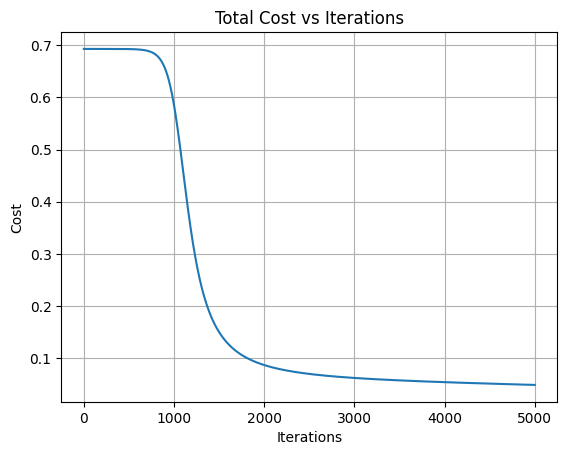

In [8]:
from matplotlib import pyplot as plt
## plot loss
plt.plot(loss_list)
plt.title("Total Cost vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.grid()
plt.show()


#### test on unseen data

In [9]:
z2, sigmoids2 = compute_forward(data_test, hidden_layer1)
z_output, output_sigmoids = compute_forward(sigmoids2, output_layer)

loss = binary_cross_entropy_loss(output_sigmoids, target_test)

print(f"predictions:\n{(output_sigmoids.reshape(target_test.shape) > 0.5).astype(int)}\nActual:\n{target_test}")
print(f"error: {loss}")

print(f"correct predictions rate: {sum( (output_sigmoids.reshape(target_test.shape) > 0.5).astype(int) == target_test ) / len(target_test) * 100 }%")



predictions:
[0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0
 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1]
Actual:
[0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0
 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1]
error: 0.029523926381482442
correct predictions rate: 100.0%


# Sklearn

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

sk_model = MLPClassifier(hidden_layer_sizes=(2,), activation='logistic',
                         learning_rate_init=0.1, max_iter=5000, solver='sgd',random_state=1)

sk_model.fit(data_training, target_training)
sk_pred = sk_model.predict(data_test)
# sk_pred = sk_model.predict(data_training)

# loss = sk_model.loss_curve_

print("Sklearn MLP Accuracy:", accuracy_score(target_test, sk_pred))
# print("Sklearn MLP Accuracy:", accuracy_score(target_training, sk_pred))

Sklearn MLP Accuracy: 1.0


Custom ANN Accuracy: 1.0


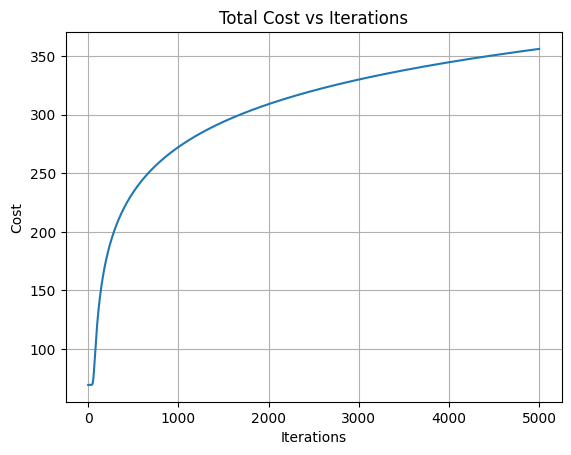

Sklearn MLP Accuracy: 1.0


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# ------------------------------------------------------
# Load & Prepare Data (Binary Classification: Class 0 vs Class 1)
# ------------------------------------------------------
iris = datasets.load_iris()

# Select only samples where target is 0 or 1
mask = iris.target < 2
X = iris.data[mask]#[:, :2]    # Only 2 features
y = iris.target[mask]         # 0 or 1


# ------------------------------------------------------
# Activation functions
# ------------------------------------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)


# ------------------------------------------------------
# Neural Network Class: 2 → 2 → 1
# ------------------------------------------------------
class SimpleANN:
    def __init__(self, learning_rate=0.1, iterations=5000):
        self.lr = learning_rate
        self.iterations = iterations
    
    def initialize_weights(self):
        np.random.seed(1)
        self.W1 = np.random.randn(4, 2) * 0.01
        self.b1 = np.zeros((1, 2))
        self.W2 = np.random.randn(2, 1) * 0.01
        self.b2 = np.zeros((1, 1))

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = sigmoid(self.Z1)

        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = sigmoid(self.Z2)

        return self.A2

    def compute_cost(self, y_hat, y):
        m = y.shape[0]
        # return -(1/m) * np.sum(y*np.log(y_hat+1e-8) + (1-y)*np.log(1-y_hat+1e-8))
        return -(1/m) * np.sum(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))


    def backward(self, X, y):
        m = X.shape[0]
        y = y.reshape(-1, 1)

        dZ2 = self.A2 - y
        # dW2 = (1/m) * np.dot(self.A1.T, dZ2)
        # db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
        dW2 = np.dot(self.A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dZ1 = np.dot(dZ2, self.W2.T) * sigmoid_derivative(self.A1)
        # dW1 = (1/m) * np.dot(X.T, dZ1)
        # db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # Update
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def fit(self, X, y):
        self.initialize_weights()
        self.costs = []

        for i in range(self.iterations):
            y_hat = self.forward(X)
            cost = self.compute_cost(y_hat, y)
            self.costs.append(cost)
            self.backward(X, y)
            # print("W1", self.W1)
            # print("b1", self.b1)
            # print("W2", self.W2)
            # print("b2", self.b2)
            # print("_____________________")

        return self

    def predict(self, X):
        return (self.forward(X) > 0.5).astype(int).flatten()


# ------------------------------------------------------
# Train Custom ANN
# ------------------------------------------------------
ann = SimpleANN(learning_rate=0.005, iterations=5000)
ann.fit(X, y)

pred = ann.predict(X)
print("Custom ANN Accuracy:", accuracy_score(y, pred))


# ------------------------------------------------------
# Plot Cost vs Iterations
# ------------------------------------------------------
plt.plot(ann.costs)
plt.title("Total Cost vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.grid()
plt.show()


# ------------------------------------------------------
# Train sklearn MLP with same architecture
# ------------------------------------------------------
sk_model = MLPClassifier(hidden_layer_sizes=(2,), activation='logistic',
                         learning_rate_init=0.2, max_iter=5000, random_state=1)

sk_model.fit(X, y)
sk_pred = sk_model.predict(X)

print("Sklearn MLP Accuracy:", accuracy_score(y, sk_pred))


In [12]:
np.concatenate([ann.b2, ann.W2]).T[:,0:1].T

array([[0.06334629]])

# Torch

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()


        # self.input = nn.Linear(2,2)
        self.hidden_layer1 = nn.Linear(4,2)
        self.output_layer = nn.Linear(2,1)

    def forward(self, x):
        # print(x)
        # x = self.input(x)
        # x = torch.sigmoid(x)
        x = self.hidden_layer1(x)
        x = torch.sigmoid(x)
        x = self.output_layer(x)

        return x
    
model = ANN()
x_vec = torch.tensor( data ).to(torch.float32)
tensor_target = torch.tensor(target).to(torch.float32)

optimizer = optim.SGD(model.parameters(), lr = 0.05)
criterion = nn.BCEWithLogitsLoss()

EPOCHS = 200
for epoch in range(EPOCHS):
    optimizer.zero_grad() ## remove old gradients


    # ----- Forward Propagation -----
    output = model(x_vec)

    # ----- Compute Loss -----
    loss = criterion(output, tensor_target.reshape(-1,1))

    # ----- Backpropagation -----
    loss.backward()
    optimizer.step()

    output = torch.sigmoid(output)
    print(f"------------------------------epoch {epoch}--------------------------------------")
    print(f"                  loss: {loss}")
    print(f"predictions:\n{(output.reshape(tensor_target.shape) > 0.5).int()}\nActual:\n{tensor_target}")
    print(f"correct prediction rate: {sum( (output.reshape(tensor_target.shape) > 0.5).int() == tensor_target ) / len(tensor_target) * 100}%")
    # print(tensor_target)
    ## get amount of correct predictions





RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x2 and 4x2)